In [3]:
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MultiLabelBinarizer
import torch
import numpy as np
import pickle
import pandas as pd
import unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
nltk.download("stopwords")
import inflect
import contractions
import re


with open('/notebook/dataframe/train_clean_df.pickle', 'rb') as f:
    train_df = pickle.load(f)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
with open('/notebook/dataframe/test_clean_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [ ]:
stopwords.words('english')

In [106]:
import pickle
import pandas as pd

with open('/notebook/dataframe/train_df', 'rb') as f:
    train_df = pd.DataFrame.from_dict(pickle.load(f))

In [111]:
train_df['title'][989948]

'"Production of a flexible, gas-tight,and transparent composite film"'

In [69]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def replace_contractions(text):
    return contractions.fix(text)

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if not word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
            new_words.append(word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words


from nltk.stem.snowball import SnowballStemmer

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stemmer = PorterStemmer()
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(sentences): # sentence
    if type(sentences) is str:
        sentences = sentences.replace('.,', '.')
        sentences = sent_tokenize(sentences)
        texts = []
        for text in sentences:
            text = remove_between_square_brackets(text)
            text = replace_contractions(text)
            words = nltk.word_tokenize(text)
            words = remove_non_ascii(words)
            words = to_lowercase(words)
            words = nltk.word_tokenize(' '.join(remove_punctuation(words)))
            words = remove_punctuation(words)
            words = replace_numbers(words)
            words = remove_stopwords(words)
            words = lemmatize_verbs(words)
            words = stem_words(words)
            texts.append(' '.join(words))
        return texts
    else:
        return None
    
def data_apply(df):
    return df.progress_apply(lambda x: normalize(x['claim']), axis=1)

def parallelize(data, func, num_of_processes=4):
    data_split = np.array_split(data, num_of_processes)
    pool = Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

In [70]:
tmp = parallelize(test_df, data_apply)

In [73]:
test_df['claim']

1         [manufactur antitag antibodi chip accord where...
2                                                      None
4         [accord wherein say oxid atmospher provid flow...
15        [hydrogen gas sensor defin wherein say first e...
16        [light apparatus vehicl door compris len mount...
                                ...                        
989942    [wherein interven layer provid enhanc layer ou...
989945    [eye track system compris camera arrang captur...
989947    [holograph project system project holograph re...
989951    [wherein network includ least one wifi network...
989954    [holograph display calcul perform provid encod...
Name: claim, Length: 198116, dtype: object

In [71]:
tmp

1         [manufactur antitag antibodi chip accord where...
2                                                      None
4         [accord wherein say oxid atmospher provid flow...
15        [hydrogen gas sensor defin wherein say first e...
16        [light apparatus vehicl door compris len mount...
                                ...                        
989942    [wherein interven layer provid enhanc layer ou...
989945    [eye track system compris camera arrang captur...
989947    [holograph project system project holograph re...
989951    [wherein network includ least one wifi network...
989954    [holograph display calcul perform provid encod...
Length: 198116, dtype: object

In [72]:
test_df['claim'] = tmp

In [7]:
train_df['clean_title'] = train_df.progress_apply(lambda x: normalize(x['clean_title']), axis=1)

In [9]:
train_df['clean_abs'] = train_df.progress_apply(lambda x: normalize(x['clean_abs']), axis=1)

In [39]:
train_df['claim'] = train_df.progress_apply(lambda x: normalize(x['claim']), axis=1)

In [74]:
with open('/notebook/dataframe/test_snowball_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [75]:
test_df

,patentKey,class3,tech_core,title,abstract,claim,ipc,encode_class3,encode_tech,claims,clean_title,clean_abs
1,ep2005010266a3,[의료 융합],[진단 조명기술],Protein interaction chip(Protein interaction c...,It is an object of the present invention to co...,[manufactur antitag antibodi chip accord where...,G01N-033/543,[928],[3341],The method for manufacturing an anti-tag antib...,[protein interact chip protein interact chip],[object present invent conduct function analys...
2,ep2005011413a1,[광 영상기기],"[LED, 레이저 프로젝션 기술]",Panoramic image projector(Panoramic image proj...,Die Erfindung betrifft ein Panorama-Bildprojek...,None,G03B-035/26 | G03B-037/00 | G03B-021/28 | H04N...,[262],[449],None,[panoram imag projector panoram imag projector],[die erfindung betrifft ein panoramabildprojek...
4,ep2005023406a3,"[산업 융합, 화합물 반도체]","[극한환경 조명 기술, 화합물 반도체용 기판 소재]",Metal oxide layer formed on substrates and its...,The present invention is directed to a new sem...,[accord wherein say oxid atmospher provid flow...,H01L-021/365 | C23C-008/10,"[616, 1354]","[1194, 3977]","The method according to claim 1, \nwherein sai...",[metal oxid layer form substrat fabric method ...,[present invent direct new semiconductor film ...
15,ep2005719311a1,"[산업용 센서, 물리/화학 특성 감지]","[환경센싱 기술, 화학센서 기술]",HYDROGEN GAS SENSOR(HYDROGEN GAS SENSOR),A first electrode and a second electrode are p...,[hydrogen gas sensor defin wherein say first e...,G01N-027/406 | G01N-027/30 | G01N-027/416,"[621, 504]","[3988, 3973]",The hydrogen gas sensor as defined in claim 1 ...,[hydrogen gas sensor hydrogen gas sensor],[first electrod second electrod provid electro...
16,ep2006014549a1,[감성조명],[플렉서블 조명 구현 기술],Lighting apparatus of vehicle door(Lighting ap...,An apparatus is provided that makes it possibl...,[light apparatus vehicl door compris len mount...,B60Q-003/02 | B60Q-003/00 | B60Q-001/32,[156],[3827],[ 청구항1 ]A lighting apparatus of a vehicle door...,[light apparatus vehicl door light apparatus v...,[apparatus provid make possibl make follow car...
...,...,...,...,...,...,...,...,...,...,...,...,...
989942,ep2015824405a1,[고정세 기술],[미세패턴 형성 기술],OLED DEVICE HAVING ENHANCEMENT LAYER(S),None,[wherein interven layer provid enhanc layer ou...,H01L-051/56 | H01L-051/50,[211],[1785],"2. The method of Claim 1 , further wherein an ...",[ole devic enhanc layer],None
989945,ep2014783494a1,[투명 디스플레이용 UI/UX],[시각공간 추적 UI/UX],HEAD AND EYE TRACKING(HEAD AND EYE TRACKING),None,[eye track system compris camera arrang captur...,A61B-005/11 | A61B-003/14 | G06T-007/20,[1254],[2330],2. An eye tracking system comprising: a came...,[head eye track head eye track],None
989947,us12300476b2,"[광학필름, RF/초고주파/밀리미터파/THz/광 소자-모듈, 홀로그래피]","[반사판, 광 소자 모듈 기술, 아날로그 홀로그램]","""Reflective optical system, tracking system an...",The invention relates to an optical reflection...,[holograph project system project holograph re...,G03H-001/26 | G02B-005/32,"[280, 105, 1347]","[1832, 1116, 2448]",[ 청구항1 ]1. Holographic projection system for p...,[reflect optic system track system holograph p...,[invent relat optic reflect system reflect ele...
989951,ep2014714059a1,[통합센서 설계],[센서 통합 설계/집적 기술],PROXIMITY DETECTION BY MOBILE DEVICES(PROXIMIT...,None,[wherein network includ least one wifi network...,H04W-008/00 | H04W-004/02 | H04L-029/08,[1250],[2190],"2. The method of claim 1, wherein the network ...",[proxim detect mobil devic proxim detect mobil...,None


In [6]:
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [22]:
np.array_split(train_df['claim'], num_cores)

[0         optoelectronic house wherein mount project cav...
 3                                                      None
 5         lightemitting diode accord wherein say support...
 6         optical network system comprise central node a...
 7         intelligent light module accord wherein light ...
                                 ...                        
 123621    transform liquid gaseous state cut process com...
 123623    produce milk drink good flavor comprise substi...
 123624    universal dig attachment accord wherein say sp...
 123625    vaccine protective mycoplasma bovis clinical d...
 123626    solid seed koji completely free wheatorigin co...
 Name: claim, Length: 98980, dtype: object,
 123627    genetic construct encode fusion protein wherei...
 123628    cotton harvester drive structure drive cotton ...
 123629    treat hooves cattle reduce bacterial infection...
 123630    isolate polynucleotide comprise nucleotide seq...
 123631    isolate polynucleotide encode 

In [19]:
from multiprocessing import Pool
import psutil
import parmap

num_cores = 8  # number of cores on your machine
print('number of cores:', num_cores)

def df_parallelize_run(df, func):
    df_split = np.array_split(df, num_cores)
    df = pd.concat(parmap.map(func, df_split, pm_pbar=True, pm_processes=num_cores))
    return df

number of cores: 8


In [36]:
df_split = np.array_split(train_df, num_cores)

In [38]:
parmap.map(normalize, df_split, pm_pbar=True, pm_processes=num_cores)

100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


[None, None, None, None, None, None, None, None]

In [109]:
normalize(train_df['title'][0])

['opto electron hous optic assembl opto electron hous optic assembl']

In [104]:
with open('/notebook/dataframe/train_df_lancast.pickle', 'wb') as f:
    pickle.dump(train_df, f)

In [ ]:
train_df['clean_title'] = train_df.apply(lambda x: normalize(x['title']), axis=1)

In [102]:
normalize(train_df['title'][14])

['biosensor biosensor measur devic method biosensor biosensor measur devic method']

In [100]:
normalize(train_df['title'][14])

['biosens biosens meas dev method biosens biosens meas dev method']

In [98]:
normalize(train_df['title'][14])

['biosensor biosensor measur devic method biosensor biosensor measur devic method']

In [95]:
normalize(train_df['title'][14])

['biosensor biosensor measure device method biosensor biosensor measure device method']

In [65]:
train_df['clean_abs'] = train_df.apply(lambda x: normalize(x['abstract']), axis=1)

In [71]:
with open('/notebook/dataframe/test_df', 'rb') as f:
    test_df = pd.DataFrame.from_dict(pickle.load(f))

In [67]:
with open('/notebook/dataframe/train_clean_df.pickle', 'wb') as f:
    pickle.dump(train_df, f)

In [73]:
test_df['claim'] = test_df.apply(lambda x: normalize(x['claims']), axis=1)
test_df['clean_title'] = test_df.apply(lambda x: normalize(x['title']), axis=1)
test_df['clean_abs'] = test_df.apply(lambda x: normalize(x['abstract']), axis=1)

with open('/notebook/dataframe/test_clean_df.pickle', 'wb') as f:
    pickle.dump(test_df, f)

In [ ]:
import json

total_dict = total_df.to_dict()

with open('/notebooks/Dataset/clean_dict/en.json','w') as f:
    json.dump(total_dict, f)

In [ ]:
import itertools
label = list(itertools.chain.from_iterable(class_target))

In [ ]:
import numpy as np

class_target = np.array(list(total_dict['class3'].values()))

import itertools
label = list(itertools.chain.from_iterable(class_target))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(label)
total_df['encode_class3'] = total_df.apply(lambda x: le.transform(x['class3']), axis=1)

class_target = np.array(list(total_dict['tech_core'].values()))
label = list(itertools.chain.from_iterable(class_target))
le = preprocessing.LabelEncoder()
le.fit(label)
total_df['encode_tech_core'] = total_df.apply(lambda x: le.transform(x['tech_core']), axis=1)

In [ ]:
total_df['encode_tech'] = total_df.apply(lambda x: le.transform(x['tech_core']), axis=1)

In [ ]:
total_df['encode_tech'] = total_df.apply(lambda x: list(x['encode_tech']), axis=1)

In [ ]:
total_df['encode_class3'] = total_df.apply(lambda x: list(x['encode_class3']), axis=1)

In [ ]:
total_df

In [ ]:
import pickle

with open('/notebooks/Dataset/clean_dict/en.pickle', 'rb') as f:
    data = pickle.load(f)

In [ ]:
import pandas as pd
import dask.dataframe as dd

total_df = pd.DataFrame.from_dict(data)
ddf = dd.from_pandas(total_df, npartitions=120)

In [20]:
def apply_normal(df):
    text = normalize(df['title'])
    if type(df['abstract']) == str:
        text.extend(normalize(df['abstract']))
    if type(df['claim']) == str:
        text.extend(normalize(df['claim']))
    return text

def apply_dask(df):
    res = df.apply(apply_normal, axis=1)
    return res

In [33]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

ddf['text'] = ddf.map_partitions(apply_dask).compute(scheduler='processes', num_worker='8')

[                                        ] | 0% Completed |  7min 53.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[######                                  ] | 16% Completed | 42min 21.6s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[###############                         ] | 39% Completed |  1hr 19min  7.8s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[#######################                 ] | 57% Completed |  1hr 55min 34.4s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[################################        ] | 80% Completed |  2hr 32min 52.2s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[####################################    ] | 90% Completed |  2hr 47min 37.4s

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[########################################] | 100% Completed |  3hr  0min 35.2s


In [52]:
import pickle
with open('/notebooks/Dataset/clean_dict/en_v1.pickle', 'wb') as f:
    pickle.dump(total_dict, f)

In [62]:
clean_df = total_df.drop(columns=['class3','tech_core','title','abstract','claim']).copy()

In [96]:
ddf = dd.from_pandas(clean_df, npartitions=60)

In [102]:
def apply_pd(df):
    sentences = df['text']
    if type(sentences) == list:
        for i,v in enumerate(sentences):
            if len(v) < 3:
                del sentences[i]
    return sentences

def apply_dask(df):
    res = df.apply(apply_pd, axis=1)
    return res

In [103]:
ddf['clean_text'] = ddf.map_partitions(apply_dask).compute(scheduler='processes', num_worker='8')

[########################################] | 100% Completed |  3min 56.2s


In [112]:
clean_df = ddf.compute()
clean_dict = clean_df.to_dict()

import pickle
with open('/notebooks/Dataset/clean_dict/en_v2.pickle', 'wb') as f:
    pickle.dump(clean_dict, f)

[########################################] | 100% Completed |  1.5s


In [129]:
res = clean_df.apply(lambda x: '||'.join(map(str,x['encode_class3'])), axis=1)
res2 = clean_df.apply(lambda x: '||'.join(map(str,x['encode_tech'])), axis=1)

In [251]:
tech_label = []
for i in range(4099):
    tech_label.append(0)
    
for i in clean_df['encode_tech']:
    if len(i) == 1:
        tech_label[int(i[0])] += 1

In [252]:
num = 0
for i,v in enumerate(tech_label):
    if v == 0:
        num += 1

In [253]:
num

262

In [244]:
tech_label = []
for i in range(60):
    tech_label.append(0)
    
for i in clean_df['encode_tech']:
    tech_label[len(i)] += 1
    
class3_label = []
for i in range(60):
    class3_label.append(0)
    
for i in clean_df['encode_tech']:
    class3_label[len(i)] += 1
    


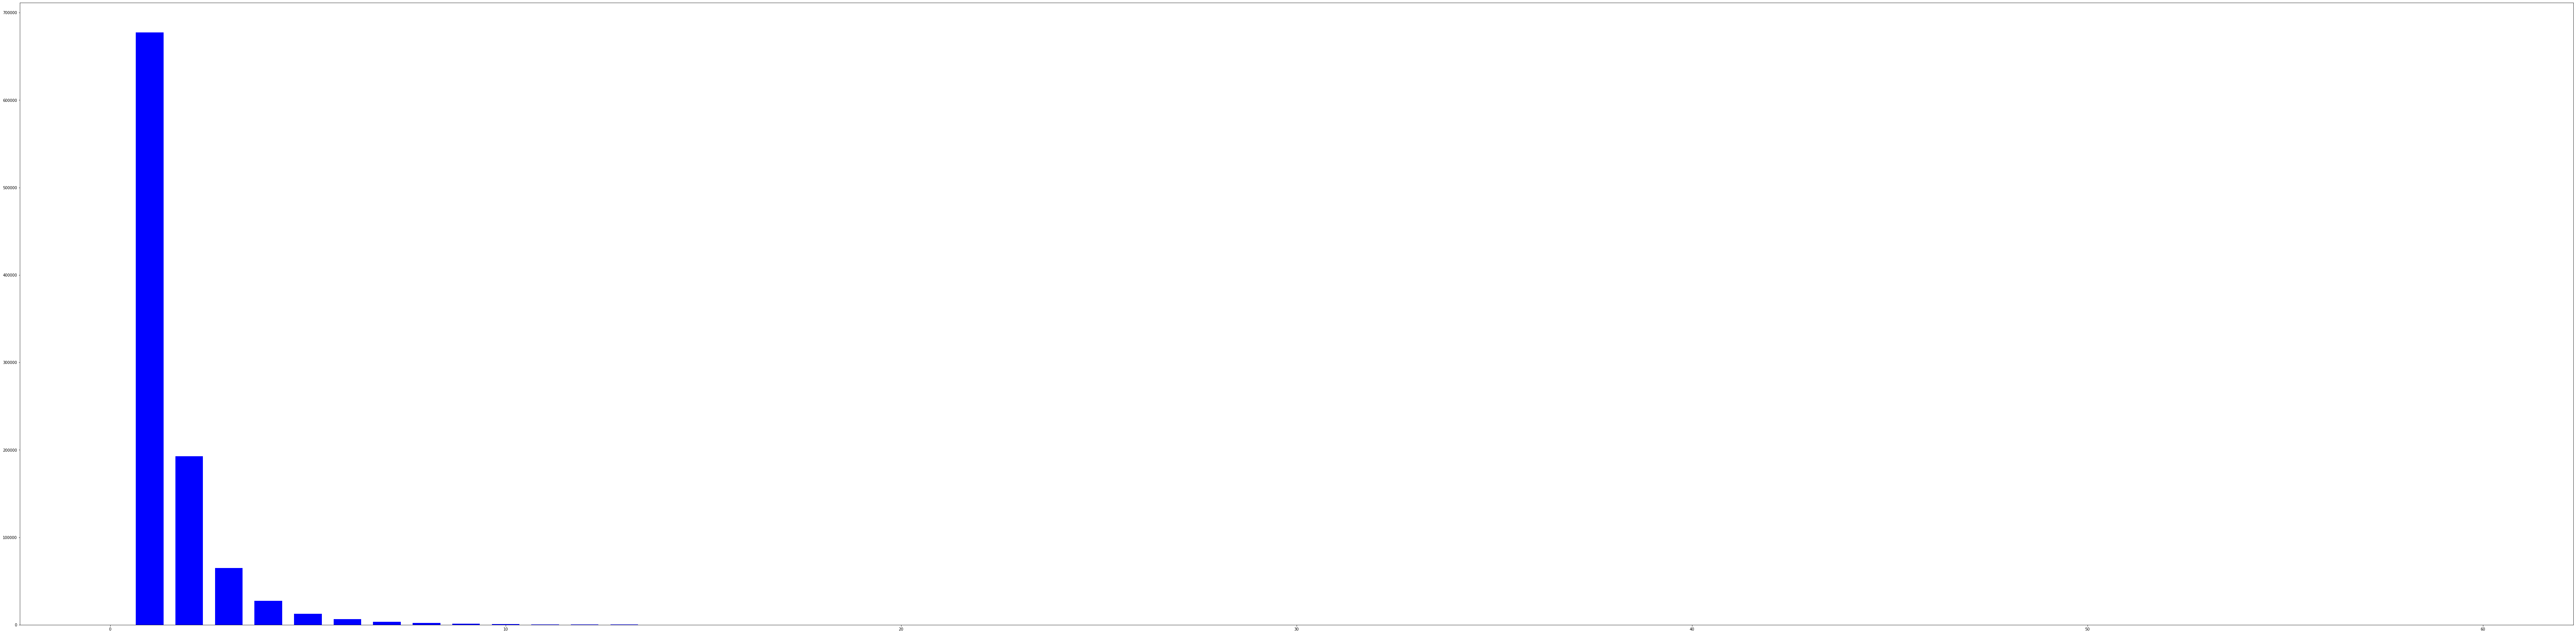

In [243]:
from matplotlib import pyplot as plt
plt.figure(figsize=(120, 30))
plt.bar(x_label[1:],class3_label[1:],width=0.7, color='blue')
plt.show()

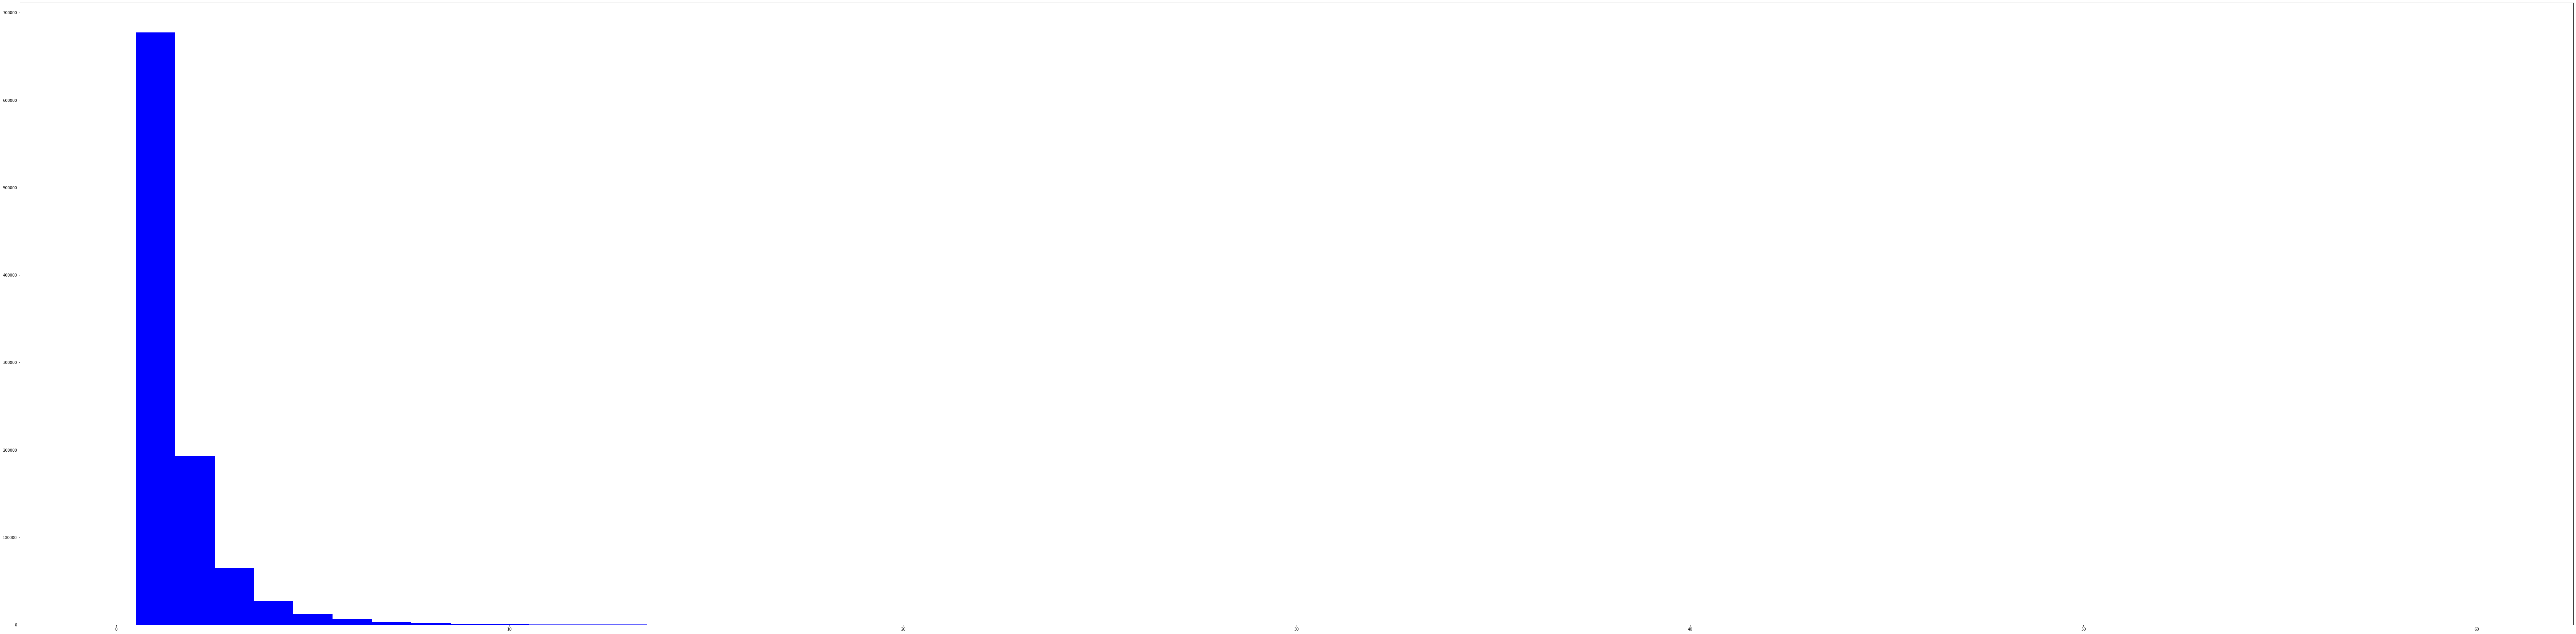

In [246]:
plt.figure(figsize=(120, 30))
plt.bar(x_label[1:],tech_label[1:], width=1, color='blue')
plt.show()

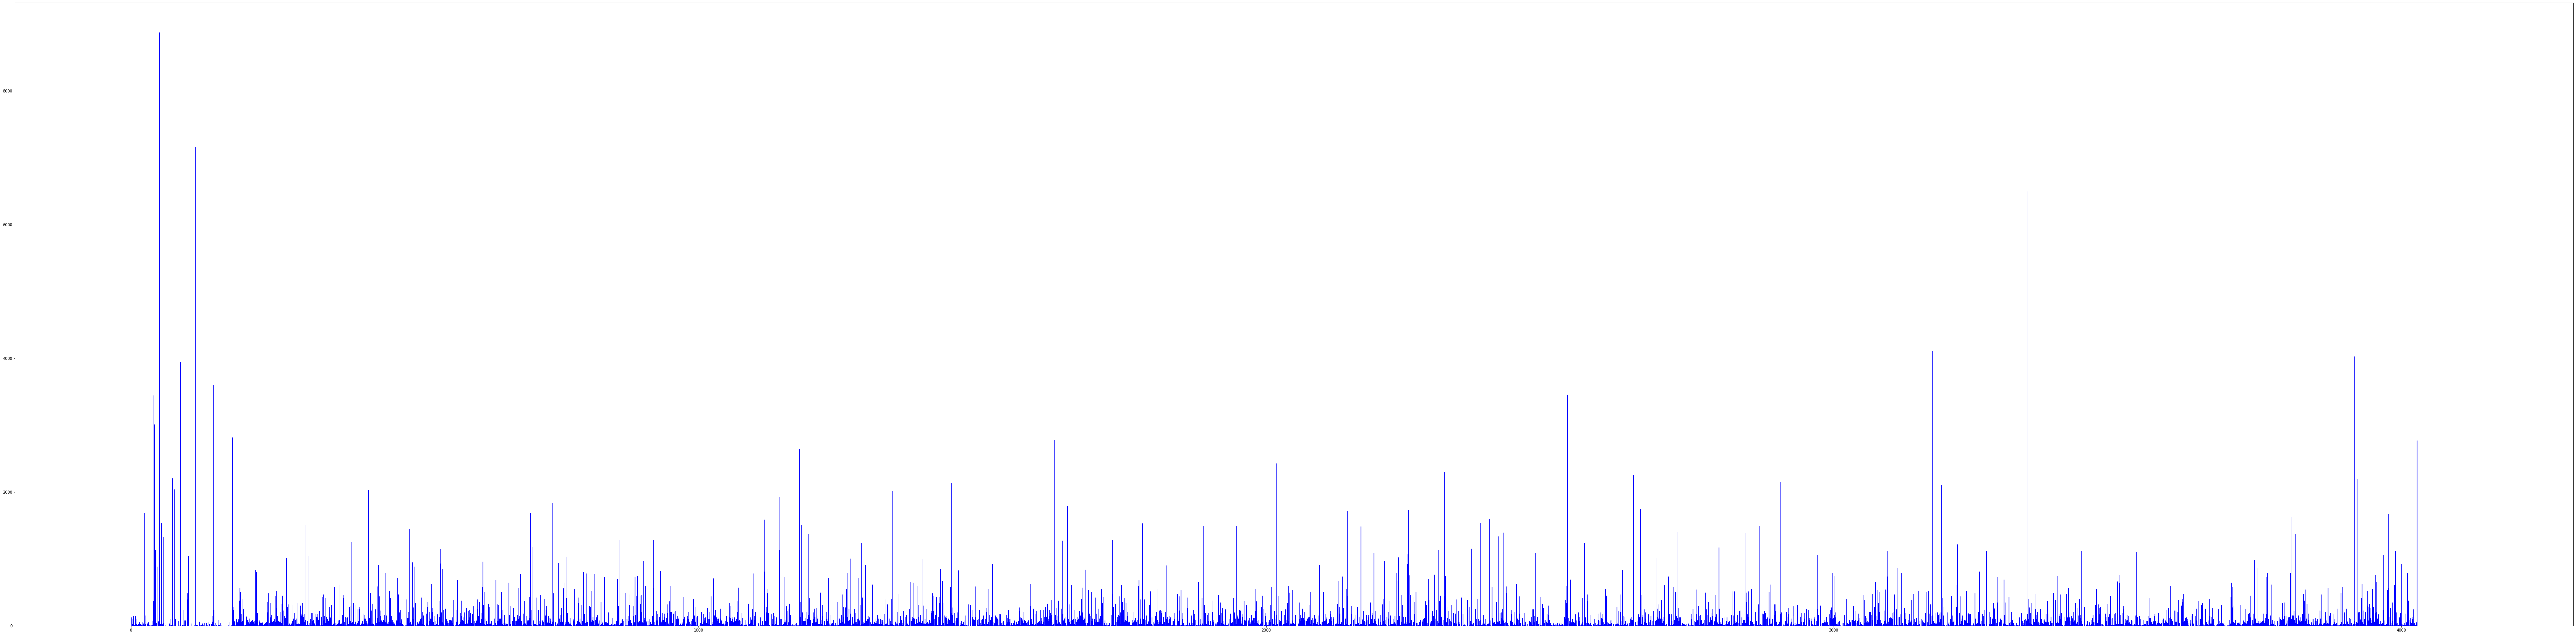

In [254]:
plt.figure(figsize=(120, 30))
plt.bar(range(4099)[1:],tech_label[1:], width=1, color='blue')
plt.show()

In [257]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(clean_df, random_state=42, test_size=0.20, shuffle=True)

In [275]:
tech_label = []
for i in range(1383):
    tech_label.append(0)

matrix = np.array

for i in clean_df['encode_class3']:
    arr = []
    for k in range(1383):
        if k in i:
            arr.append(1)
        arr.append(0)
    np.append(matrix,np.array(arr))

KeyboardInterrupt: 

In [343]:
class_target = np.array(list(total_dict['encode_class3'].values()))
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(class_target)
x = mlb.fit_transform(class_target)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in msss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [     2      3      4 ... 989950 989952 989953] TEST: [     0      1      8 ... 989949 989951 989954]


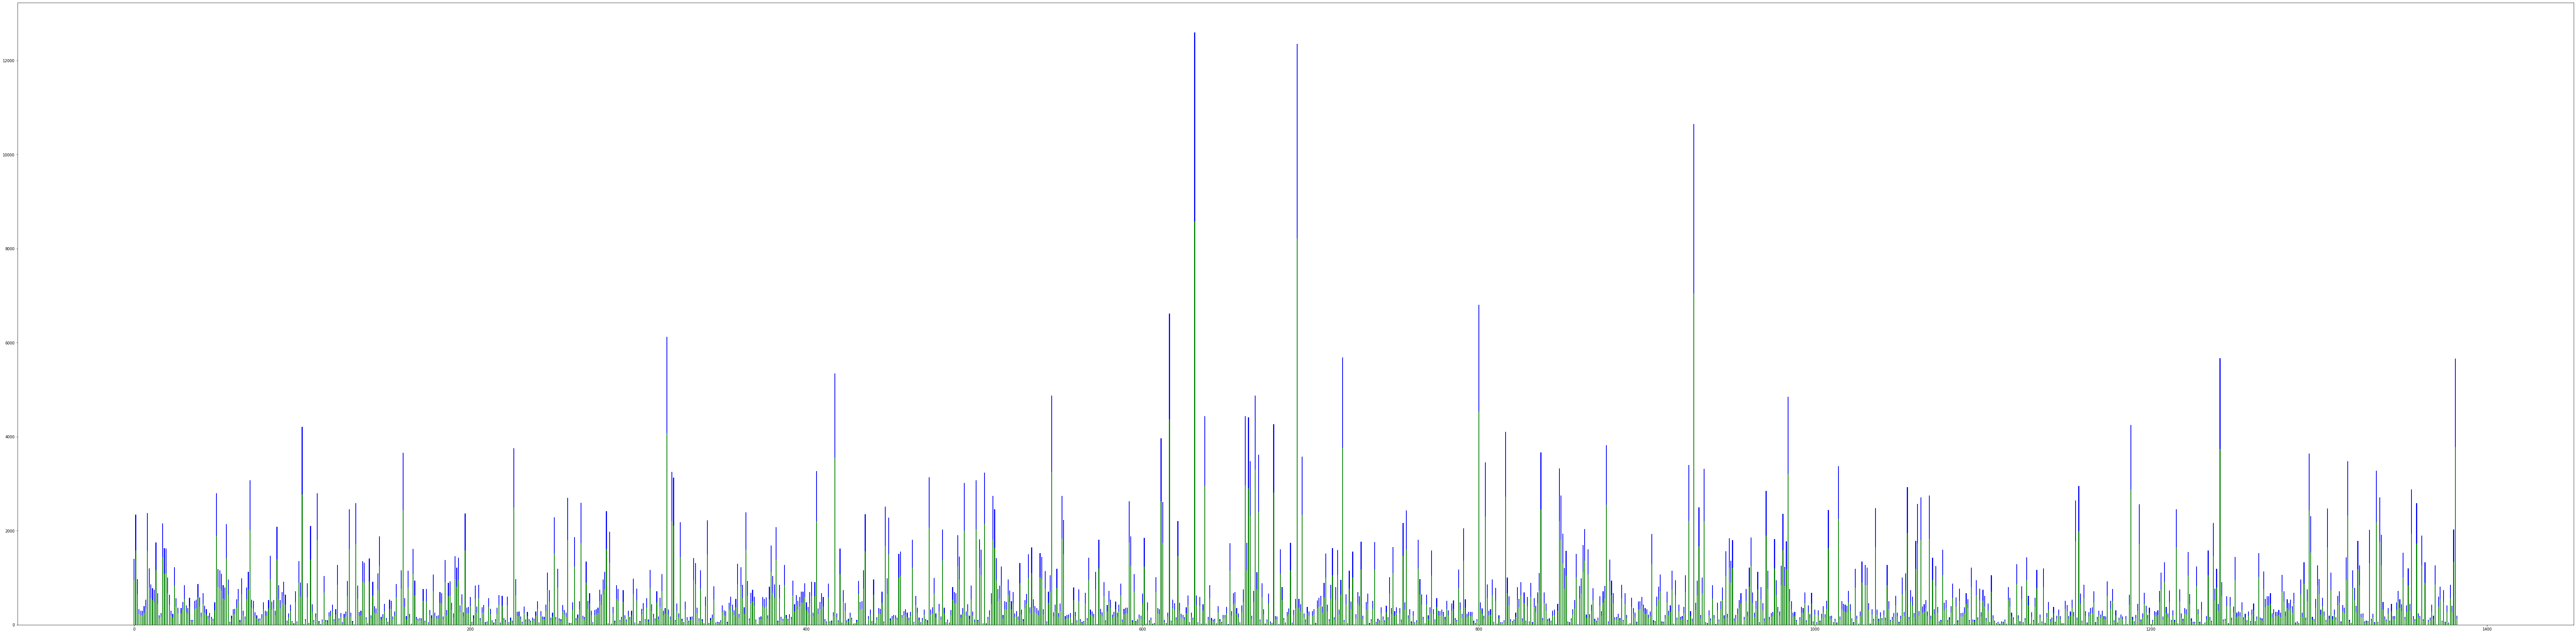

In [349]:
train_label = []
for i in range(1383):
    train_label.append(0)
    
for i in train_set['encode_class3']:
    for j in i:
        train_label[j] += 1
        
test_label = []
for i in range(1383):
    test_label.append(0)
    
for i in test_set['encode_class3']:
    for j in i:
        test_label[j] += 1
        
plt.figure(figsize=(120, 30))
ax = plt.subplot(111)
ax.bar(range(1383),train_label, width=0.5, color='b', align='center')
ax.bar(range(1383),test_label, width=0.5, color='g', align='center')
plt.show()

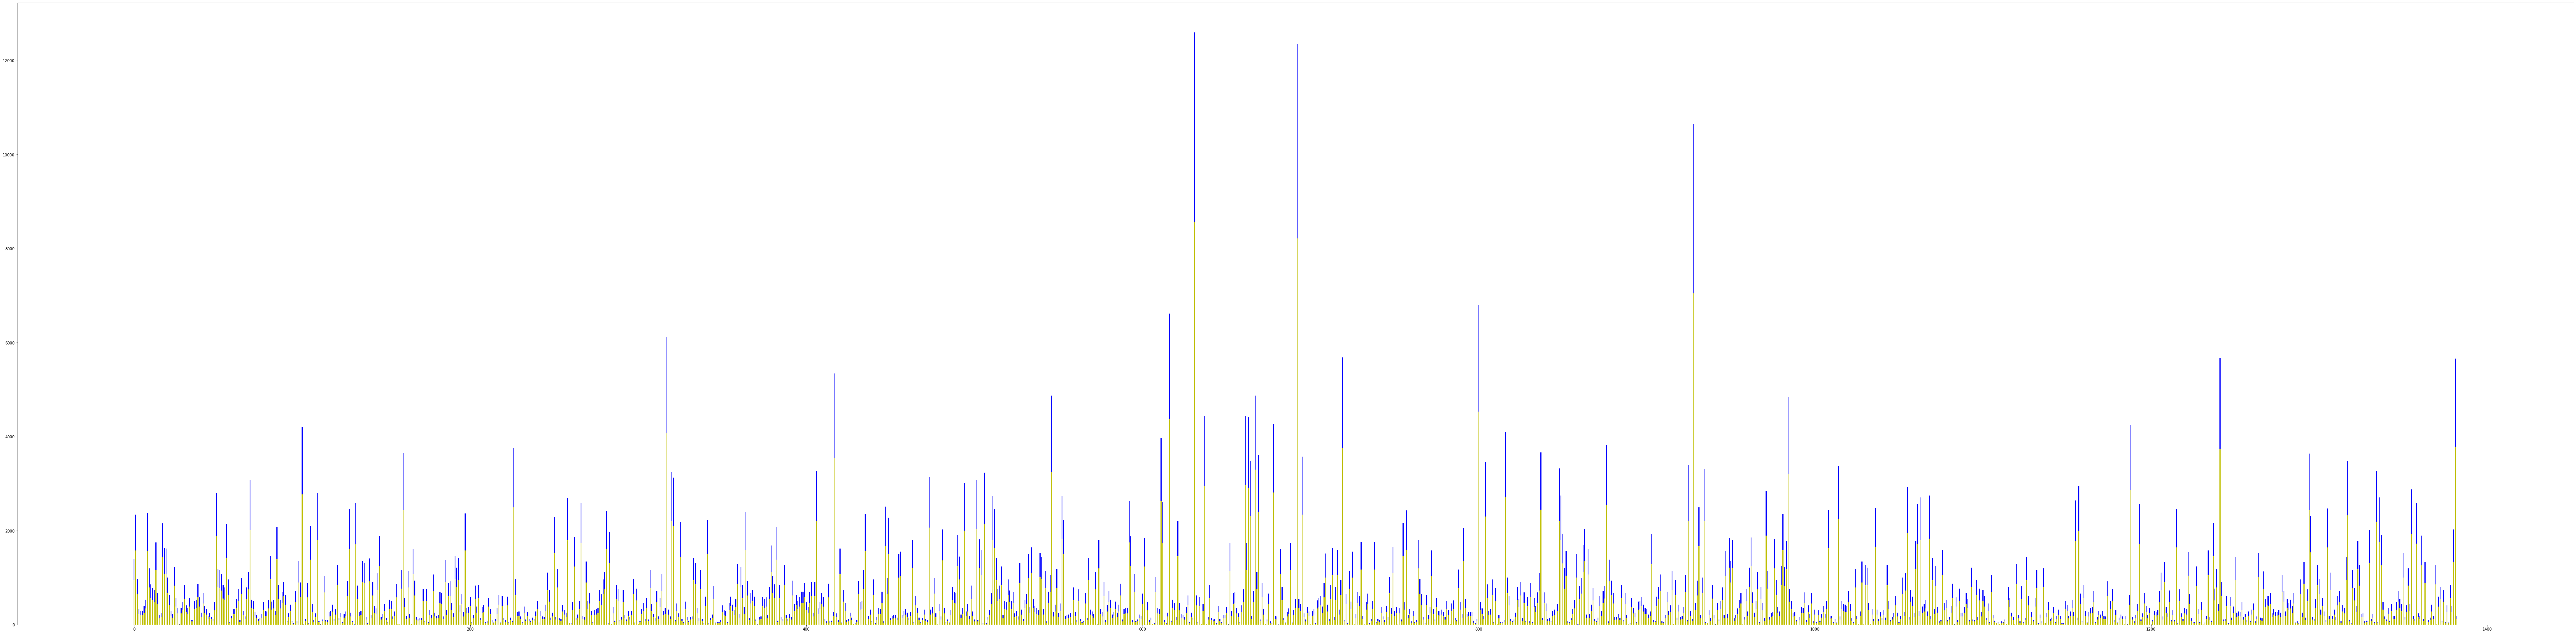

In [350]:
plt.figure(figsize=(120, 30))
ax = plt.subplot(111)
ax.bar(range(1383),train_label, width=0.5, color='b', align='center')
ax.bar(range(1383),test_label, width=0.5, color='y', align='center')
plt.show()

In [348]:
train_set = clean_df.iloc[list(train_index)].copy()
test_set = clean_df.iloc[list(test_index)].copy()

train_set = train_set.drop(columns = ['patentKey','encode_tech'])
test_set = test_set.drop(columns = ['patentKey','encode_tech'])

with open('/notebooks/Dataset/en/class_train2.pickle', 'wb') as f:
    pickle.dump(train_set, f)
    
with open('/notebooks/Dataset/en/class_test2.pickle', 'wb') as f:
    pickle.dump(test_set, f)

In [2]:
import pickle

with open('/notebooks/Dataset/clean_dict/en_v2.pickle', 'rb') as f:
    total_dict = pickle.load(f)

In [7]:
with open('/notebooks/Dataset/clean_dict/en_v3.pickle', 'rb') as f:
    tmp = pickle.load(f)

In [8]:
tmp['clean_text'][0]

['optoelectronic house optical assembly optoelectronic house optical assembly',
 'optoelectronic house 101 optoelectronic assembly',
 'house include enclosure define cavity',
 'open 107 wall enclosure adapt receive substrate',
 'mount 113 project cavity opposite open',
 'mount adapt support optoelectronic device 115',
 'adjacent mount optically transmissive region 117 wall enclosure',
 'optoelectronic assembly also include substrate 147 dispose open optoelectronic device support mount']

In [9]:
total_dict['clean_text'] = tmp['clean_text']

In [11]:
import pickle

with open('/notebooks/Dataset/clean_dict/en_final.pickle', 'wb') as f:
    pickle.dump(total_dict,f)

In [17]:
import numpy as np

class_target = np.array(list(total_dict['encode_class3'].values()))
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(class_target)
x = np.zeros((len(y),1),dtype=int)

In [22]:
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in msss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [     0      3      5 ... 989950 989952 989953] TEST: [     1      2      4 ... 989947 989951 989954]


NameError: name 'X' is not defined

In [26]:
import pandas as pd

clean_df = pd.DataFrame.from_dict(total_dict)

In [27]:
train_set = clean_df.iloc[list(train_index)].copy()
test_set = clean_df.iloc[list(test_index)].copy()

In [30]:
print(len(train_set), len(test_set))

791839 198116


In [31]:
train_set = train_set.drop(columns = ['patentKey','encode_tech'])
test_set = test_set.drop(columns = ['patentKey','encode_tech'])

with open('/notebooks/Dataset/en/class_train3.pickle', 'wb') as f:
    pickle.dump(train_set, f)
    
with open('/notebooks/Dataset/en/class_test3.pickle', 'wb') as f:
    pickle.dump(test_set, f)

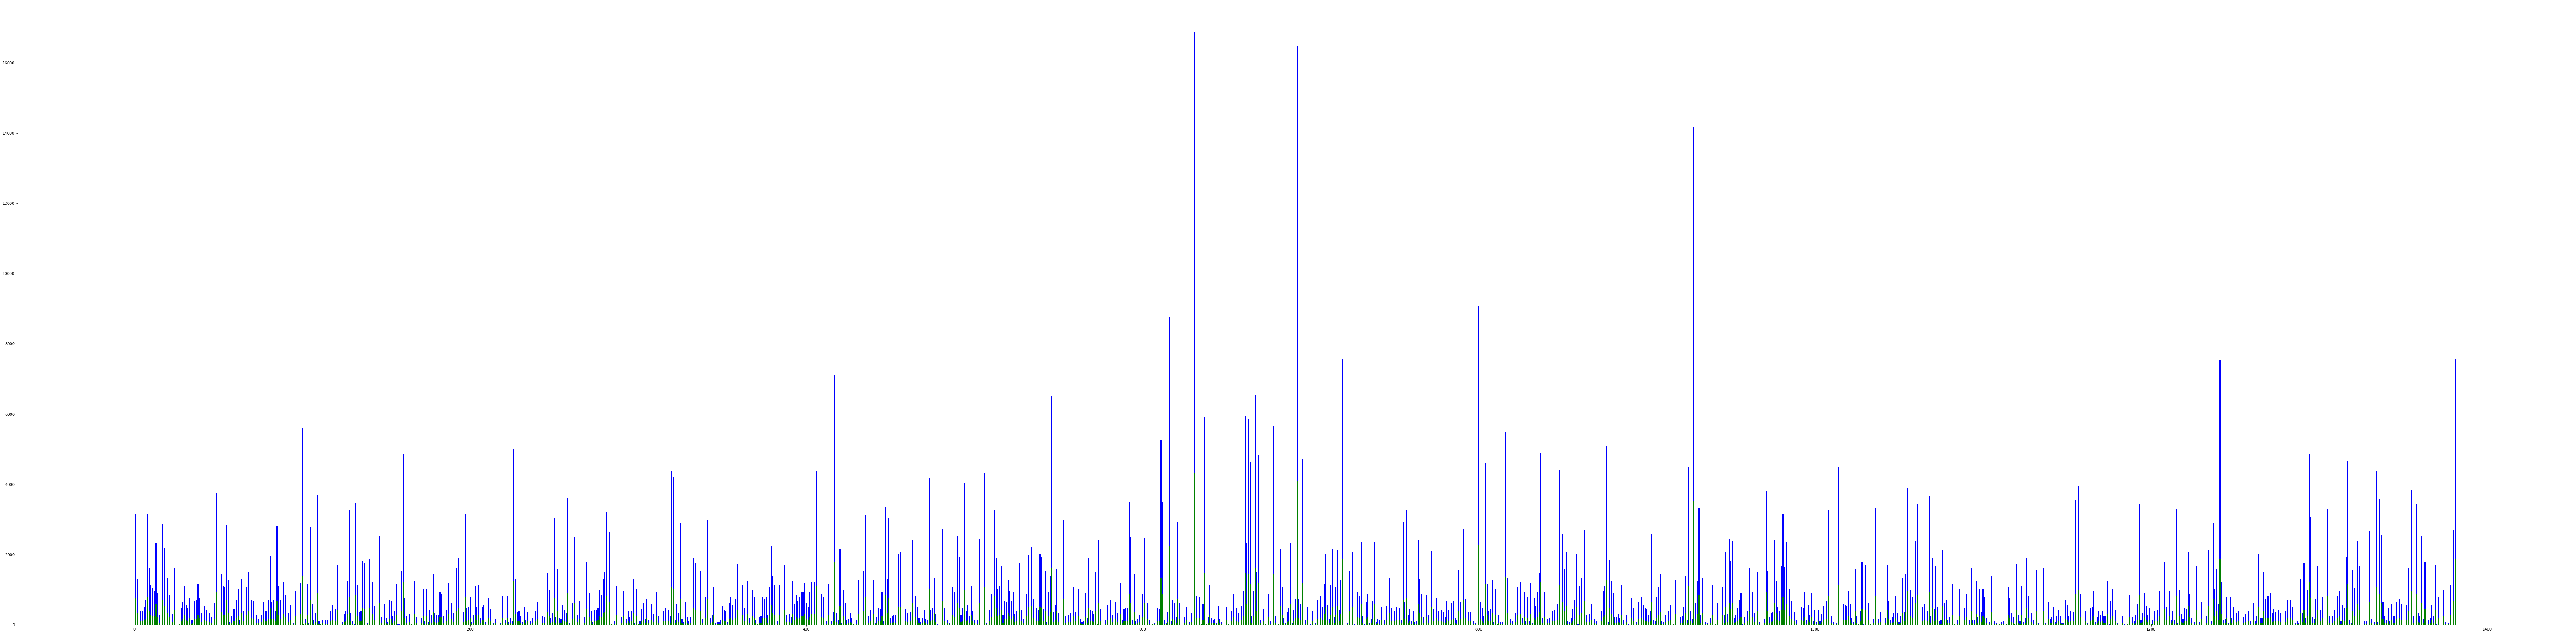

In [34]:
import matplotlib.pyplot as plt

train_label = []
for i in range(1383):
    train_label.append(0)
    
for i in train_set['encode_class3']:
    for j in i:
        train_label[j] += 1
        
test_label = []
for i in range(1383):
    test_label.append(0)
    
for i in test_set['encode_class3']:
    for j in i:
        test_label[j] += 1
        
plt.figure(figsize=(120, 30))
ax = plt.subplot(111)
ax.bar(range(1383),train_label, width=0.5, color='b', align='center')
ax.bar(range(1383),test_label, width=0.5, color='g', align='center')
plt.show()

In [37]:
0 in train_label

False

In [38]:
0 in test_label

True

In [353]:
# balanced tech core label split 8:2 Data 1
class_target = np.array(list(total_dict['encode_tech'].values()))
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(class_target)
x = mlb.fit_transform(class_target)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in msss.split(x, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [     0      1      5 ... 989951 989952 989953] TEST: [     2      3      4 ... 989947 989950 989954]


In [354]:
train_set = clean_df.iloc[list(train_index)].copy()
test_set = clean_df.iloc[list(test_index)].copy()

train_set = train_set.drop(columns = ['patentKey','encode_class3'])
test_set = test_set.drop(columns = ['patentKey','encode_class3'])

with open('/notebooks/Dataset/en/tech_train1.pickle', 'wb') as f:
    pickle.dump(train_set, f)
    
with open('/notebooks/Dataset/en/tech_test1.pickle', 'wb') as f:
    pickle.dump(test_set, f)

In [39]:
train_index

array([     0,      3,      5, ..., 989950, 989952, 989953])

In [ ]:
import numpy as np

# balanced tech core label split 8:2 Data 2
class_target = np.array(list(df['encode_tech']))
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
x = mlb.fit_transform(classz_target)
y = np.zeros((len(x),1),dtype=int)

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
import numpy as np

msss = MultilabelStratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=0)

for train_index, test_index in msss.split(y, x):
    print("TRAIN:", train_index, "TEST:", test_index)
    y_train, y_test = y[train_index], y[test_index]
    x_train, x_test = x[train_index], x[test_index]

In [ ]:
train_set = clean_df.iloc[list(train_index)].copy()
test_set = clean_df.iloc[list(test_index)].copy()

train_set = train_set.drop(columns = ['patentKey','encode_class3'])
test_set = test_set.drop(columns = ['patentKey','encode_class3'])

with open('/notebooks/Dataset/en/tech_train2.pickle', 'wb') as f:
    pickle.dump(train_set, f)
    
with open('/notebooks/Dataset/en/tech_test2.pickle', 'wb') as f:
    pickle.dump(test_set, f)

In [ ]:
train_label = []
for i in range(1383):
    train_label.append(0)
    
for i in train_set['encode_class3']:
    for j in i:
        train_label[j] += 1
        
test_label = []
for i in range(1383):
    test_label.append(0)
    
for i in test_set['encode_class3']:
    for j in i:
        test_label[j] += 1
        
plt.figure(figsize=(120, 30))
ax = plt.subplot(111)
ax.bar(range(1383),train_label, width=0.5, color='b', align='center')
ax.bar(range(1383),test_label, width=0.5, color='g', align='center')
plt.show()

In [3]:
with open('/notebook/AttentionXML/data/train.txt', 'r') as f:
    texts = [line[:-1].split() for line in f.readlines()]

In [2]:
from nltk.stem.snowball import SnowballStemmer

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [4]:
stem_words(texts[0])

NameError: name 'LancasterStemmer' is not defined